## Overview

Ammunition manufactures provide a wealth of data for their cartridges. These data allow shooters to determine how 'flat' the trajectory of the rounds are and make adjustments for the drop and slow down of bullets when shooting at long range.

In this assignment we will use these data and see how well we can match observations to the output of a computational model. Scientists have been creating so-called ballistic models since the turn of the last century, driven by the military and the importance of artillery. Such models allow for:

* the anticipation of the long range characteristics of projectiles,
* engineers can answer 'what if' questions like what would be the the result of a lower drag bullet vs. a cartridge with more powder (a faster muzzle velocity), and
* provide a high-order, physics-based interpolation between observations.

In this class we will reproduce a pair of famous ballistic models - the G1 and G7 models. Results of these models will be compared to the data from ammunition manufactures.

If hunting isn't your thing, this project has parallels to computing the point a projectile falling from orbit impacts the Earth; think SpaceX capturing a rocket with `chopsticks'. The objectives of the lesson are to:

* gain an understanding of two dimensional motion, the ODEs that arise, and how they are solved with a computer.
* create modules for both data storage/retrieval and dynamical modeling.
* do a simple optimization.
* relate results in a tabular form.

Finally, this assignment will emulate a project, of which there are three in this class, amounting to 45\% of undergraduate grades, and 30\% of graduate student grades. Here, you'll get the chance to try it out without stakes, and see how I would grade it.

### Two dimensional motion and solving ODEs

Until today, the ODEs we solved had only one dimension. For success with a projectile, we will need two dimensions. $x$ will be used to represent the range of the projectile - how far it travel over the Earth's surface. The $y$ axis will represent the drop in the projectile as it moves down range and is parallel to the direction gravity operates in.

Let us suppose that we now have some vector drag force, $\mathbf{F_d}$. The equations of motion would be

$$\mathbf{F} = m \mathbf{a} = m\mathbf{g} - \mathbf{F_d}$$

where we note that all quantities in **boldface** are vectors. That means that it's easier to write equations for $x$ and $y$ separately. Those are

$$ a_x = ~~- \mathbf{F_d}/m  \cdot \mathbf{\hat x}$$
$$ a_y = g - \mathbf{F_d}/m  \cdot \mathbf{\hat y}$$

Where $\mathbf{\hat x}$ is the unit vector in the $x$ direction and likewise for $\mathbf{\hat y}$. The mass has been divided through. These equations indicate that the drag force must be projected onto each of the two cardinal axes. We will return to this later.

Lets conclude with a clear statement about what we require of the ODE solver. The $\mathbf{y_o}$ will be the initial state and consist of $(x^o,y^o,v^o_x,v^o_y)$; the 2 initial positions and 2 initial velocities. The function you write to pass to the ODE solver will return $(v_x^i,v_y^i,a_x^i,a_y^i)$; the 2 velocities and the 2 accelerations at time $t_i$, given $(x^i,y^i,v_x^i,v_y^i)$. The ODE solver function itself will return a sequence of states from the specified initial time, $t_o$ until $t_f$, progressing by the time interval $\Delta t$.

### In-class
Write the ODE function that specifies the above drag equations in 2D. Assume that an object, instead of a parameter is passed to the function. This object includes a function `get_drag` that will accept a magnitude of velocity, $|\mathbf{v}|$ and return the magnitude of the drag force. Also assume the object contains $g$, the gravitational acceleration.


In [68]:
import numpy as np

def projectile(t,y,b):
  x, y, vx, vy = y
  speed = np.sqrt(vx**2 + vy**2)

  g = b.g
  drag = b.get_drag(speed)

  u_x = vx / speed
  u_y = vy / speed

  ax = -drag * u_x
  ay = g - (-drag * u_y)

  return np.array([vx, vy, ax, ay])


## The drag force
The drag force will be significant in determining the projectile's path. We begin with the following commonly used expression for drag force
$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

$C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air the projectile travels through [Wikipedia:Density of Air](https://en.wikipedia.org/wiki/Density_of_air), $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. Mass, if you are wondering, is drawn into $C_d$.

### The ballistic coefficient
Using the basic equation for drag force presents a problem. How will we determine $C_d$ for each of the many different bullets that are available? Further, we expect $C_d$ to be a function of the speed of the projectile, $C_d(v)$. This is too much measurement and too much fitting. Instead, consider the following strategy.

$S_d = \frac{m}{A}$ is the [Wikipedia:Sectional density](https://en.wikipedia.org/wiki/Sectional_density) of the projectile. It is the mass $m$ divided by the cross-sectional area $A$  of the bullet.

The form factor of a bullet is $f=\frac{C_d}{C^{\mathbf{G}}_{d}}$, where $C_d$ is the bullet's coefficient of drag, and $C^{\mathbf{G}}_{d}$ is the drag of a reference round. Here, we learn that $C_d$ isn't known, but that the calculation is done with respect to a round it is known for, called a *reference model*. That's the so-called G model, it is no more than a set of measurements for a single, 'reference' projectile. We will see that this ratio produces nice simplifications in the drag equation.

The **ballistic coefficient** is then the amount a bullet slows down in flight relative to a reference round. Based on the previous relations, this is expressed as

$$b_c = \frac{S_d}{f}.$$

This is the number provided by the manufactures to tell shooters how well the bullet travels through the air. A value of 1.0 means the bullet has the same drag as the reference round. A value of greater than one would indicate the bullet experiences less drag than the reference round. A value less than one indicates the bullet experiences more drag than the reference round. Note that because of the dependence on $C^{\mathbf{G}}_{d}$ the ballistic coefficient is always with respect to some reference. Most manufactures report ballistic coefficients for G1 reference bullets only and use imperial units of measure. This has a tendency to make the value higher, which shooters like. The same value expressed for the (usually superior) G7 model is lower. So even if the model is better, the lower number turns off shooters that what to think bigger is better, so G1 remains, even if it was formulated in 1881 and involves a one pound bullet!

**Note the units of the ballistic coefficient.** They are pounds per inch squared in imperial units, and most manufactures report them in imperial units. To get to metric, you must convert to kilograms per meter squared.

In conclusion, to model the trajectory of a round, one uses published data on a reference round, and then computes how much the trajectory changes for a particular round. The difference between the reference round and the round in question is expressed as the inverse of the ballistic coefficient, $b_c$. A value of $b_c$ less than one indicates the round is impacted more by air resistance than the reference round. A value of $b_c$ greater than one indicates the projectile experiences less air resistance than the reference round.

### Final form of drag force

***Students do this in class***
To complete the analysis, multiply the right hand side of the original drag relation by one in the form of $\frac{b_c}{b_c}$. Write out the expression for $b_c$ based on the above discussion of sectional density and form factor. Replace the $b_c$ in the numerator with that. Achieve some cancelations and substitutions. Divide through by mass to give acceleration instead of force. Generalize $C_d$ to $C_d(m)$, where $m$ is the Mach number of the projectile,

$$m = \frac{|\mathbf{v}|}{v_s}.$$

Here, $v_s$ is the speed of sound in air, see here for tables: [Wikipedia: Density of Air](https://en.wikipedia.org/wiki/Density_of_air).

***Check answer***

As a result, any round's trajectory is expressed as a reference round's trajectory scaled by the ballistic coefficient of the particular round. This gives the following friction relation

$$ \mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}.$$

Partitioning the force into ''x'' and ''y'' components based on the $\mathbf{\hat v}$, the equations of motion for the bullet take the following form

$$ a_x = ~~ - \frac{1}{2b_c}\rho C_d^G(m) v^{2}\frac{v_x}{|\mathbf{v}|}$$

$$a_y =  -g - \frac{1}{2b_c}\rho C_d^G(m) v^{2}\frac{v_y}{|\mathbf{v}|}$$

***In class***
Write a function that returns the magnitude of the drag function. Assume you have access to the other parts of the calculation, such as helper functions to convert units, a variable that sets the units, and whatever constants are needed.

#### Difference in models
We will use both the G1 on G7 models, but what's the difference? It has to do with the projectile the data is taken on. The 'standard' projectiles of G1 and G7 are different.

![G1 vs. G7 standard projectiles](Gmodels.png)

Above, you can see the G7 model is based on a more modern, low drag bullet that has a 'boat tail' end and longer nose. The G1 is an older type of round that's mostly historical in terms of shape. It also weighed a full pound!

A rule of thumb here might be that the more the model looks like the bullet you use, the better you'll do.

### Tables of Data
The data is tabulated in the form of Mach number $m$ in the first column and $K_d$ in the second. $K_d$, what's that? Well it's an older way of relating the data. You'll need to apply the correction that

$$ C_d = \frac{\pi}{4} K_d$$

to bring the values in the tables into agreement with the drag model we develop.

Data are from [here](https://www.jbmballistics.com/ballistics/downloads/downloads.shtml)

The relations are explored in a graph below.

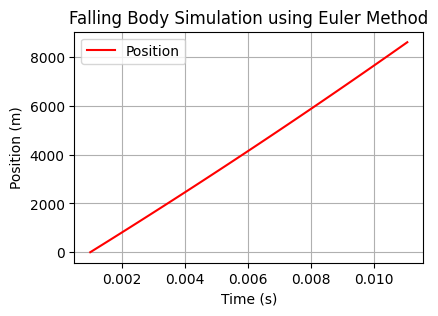

In [69]:
from scipy.interpolate import interp1d
from sim import G1, G7, EulerRichardson, solve_ode
import math
import matplotlib.pyplot as plt
import numpy as np

class BallisticModel:
    def __init__(self):
        self.bc_G7 = 0.212 * 703.5  # ballistic coefficient for G7 model lb/in^2
        self.rho = 1.2041            # air density (kg/m^3)
        self.vs = 343.21             # speed of sound (m/s)
        self.v0 = 800                # initial velocity (m/s)
        self.x0 = 0                 # initial x position (m)
        self.y0 = 0.04064            # initial y position (m) == 1.6 in
        self.g = 9.81

        self.G7 = self.preprocessing(G7)
        self.cd_G7 = self.interpolate(self.G7)

    def preprocessing(self, data):
        data[:, 1] = data[:, 1] * (math.pi / 4)
        return data

    def interpolate(self, data):
        return interp1d(data[:, 0], data[:, 1], kind='linear', fill_value="extrapolate")

    def get_drag(self, v):
        mach = v / self.vs
        cd = self.cd_G7(mach)
        drag = 0.5 * (1 / self.bc_G7) * self.rho * v**2 * cd
        return drag


dt = 0.1
y0 = np.array([0.001, 0.04064, 0.001, 800])
tspan = (0, 10)
t, y = solve_ode(projectile, tspan, y0, EulerRichardson, BallisticModel(), first_step=dt)

plt.figure(figsize=(4.5, 3))

plt.plot(y[:, 0], y[:, 1], 'r-', label='Position')
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.title('Falling Body Simulation using Euler Method')
plt.legend()
plt.grid(True)




### Assignment
* Develop a class to encapsulate the data for the G1 and G7 models. These data are expressed in the tables that appear below. The class should also have a function to return the drag, relevant constants, facilities to convert from imperial to metric, and perform interpolation of the tabular data.
* Select a cartridge that includes long range (800 meters or more) trajectory data and ballistic coefficients for both models. That's not always easy, manufacturers often have incomplete data on ballistic coefficient used (G1 but not G7). Some manufacturers you might check can be found [here](https://en.wikipedia.org/wiki/Category:Ammunition_manufacturers) . A good fallback is the Finnish company, [Lapua](https://www.lapua.com/ammunition/tactical-cartridges/), which is excellent in terms of providing data. So is [Horandy](https://www.hornady.com/). Class is more fun if a variety of cartridges are studied. Do not use handgun rounds. They don't travel far enough.
* You will need to devise a method for making certain that the projectile is zeroed at the appropriate point on the trajectory. To do this, the projectile must be fired at an angle with respect to horizontal making initial velocities $v^0_x = v_m cos\theta$ and $v^0_y = v_m sin\theta$, where $v_m$ is the muzzle velocity of the cartridge you select.
* Take into account the scope is above the barrel. As such, if the manufacturer does not report it, set the initial position to -5 cm below the zero.
* Compare the trajectory of the cartridge you select to the trajectory produced by each of the models. Do so with both graphs and well printed tables. I used Python's "`prettytable`".
* Provide commentary on which ballistic model appears to be best suited to your cartridge. You will also need to develop a quantitative metric for assessing the ''goodness of fit'' of the model to the data. Note that the ballistic coefficient is with respect to each model (a different reference bullet is used). Don't forget that the ballistic coefficient has dimensions.
* Improve upon the model in some way. This could be improvising a $C_d$ curve that is more suitable for your round, by improving the $\rho$ model, by implementing another G type model (see below, several are available), or something else you might dream up. I found that reading the [Wikipedia: Ballistic Coefficient](https://en.wikipedia.org/wiki/Ballistic_coefficient) page stirred my imagination. Show the improvement for your round, and then, without further optimization, try your improved model on a new cartidge. Did it do better for that cartidge too?
